## Importing Libraries and Dataset

In [ ]:
import csv, sys
csv.field_size_limit(sys.maxsize)

131072

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(
    '/content/drive/MyDrive/data.csv',
    sep='§')

Mounted at /content/drive


<ipython-input-3-2095871506>:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
color_map = {
    'High': '#1f77b4',
    'Medium': '#ff7f0e',
    'Low': '#2ca02c'
}

order = ['High', 'Medium', 'Low']

## roBERTa

### Model Setup and Data Preparation

In [ ]:
#roBerta base model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# fillna
df['Cleaned_Body_n'] = df['Cleaned_Body_n'].fillna("")

def roberta_sentiment(text: str) -> float:
    text = text.replace("\n", " ").strip()
    encoded = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
      out = model(**encoded)
    scores = out.logits[0].cpu().numpy()
    probs = softmax(scores)
    return float(((probs[2] - probs[0])/ (probs[2] + probs[0]))) # positive-negative

# sentiment
tqdm.pandas(desc="Sentiment_roberta")
df['Sentiment_roberta'] = df['Cleaned_Body_n'].progress_apply(roberta_sentiment)

df['year_month'] = pd.to_datetime(df['year_month'])

Sentiment_roberta: 100%|██████████| 267774/267774 [42:07<00:00, 105.92it/s]


### Sentiment Evolution by Hierarchical Level

<ipython-input-10-1217907292>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='year_month', freq='2M'), 'Level'])


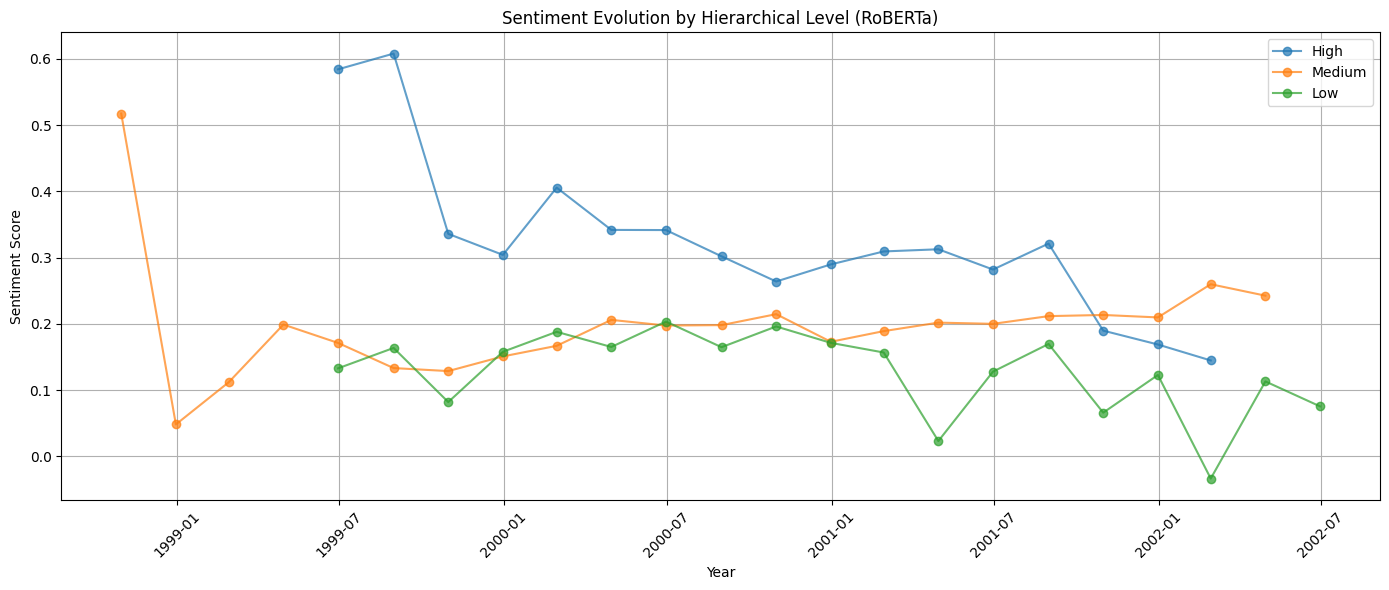

In [ ]:
min_count = 5

agg = (
    df.groupby([pd.Grouper(key='year_month', freq='2M'), 'Level'])
    .agg(Sentiment=('Sentiment_roberta', 'mean'), Count=('Sentiment_roberta', 'count'))
    .reset_index()
)

agg = agg[agg['Count'] >= min_count]

pivot = agg.pivot(index='year_month', columns='Level', values='Sentiment').sort_index()

pivot = pivot.reindex(columns=[lvl for lvl in order if lvl in pivot.columns])

plt.figure(figsize=(14, 6))

for lvl in pivot.columns:
    plt.plot(pivot.index, pivot[lvl], marker='o', linestyle='-', alpha=0.7, label=f"{lvl}",color=color_map.get(lvl, 'gray'))

plt.title("Sentiment Evolution by Hierarchical Level (RoBERTa)")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Average Sentiment

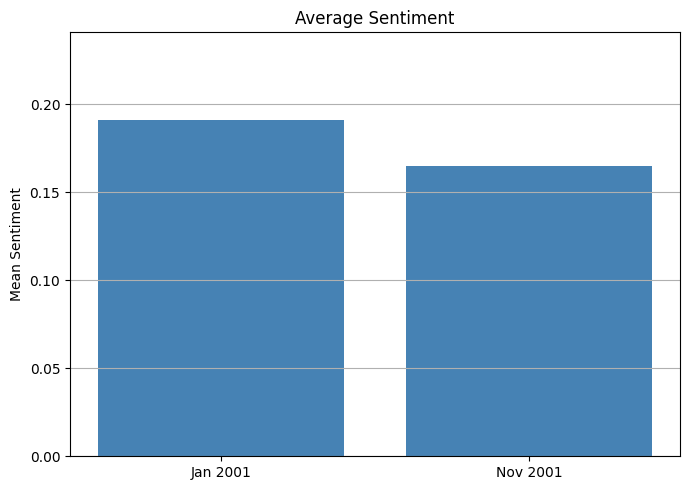

In [ ]:
#roberta
import pandas as pd
import matplotlib.pyplot as plt

# Threshold
threshold = 0.1
df['year_month'] = pd.to_datetime(df['year_month'])

# fliter for the months
a_2001 = df[df['year_month'] == '2001-01']
b_2001 = df[df['year_month'] == '2001-11']

mean_a = a_2001['Sentiment_roberta'].mean()
mean_b = b_2001['Sentiment_roberta'].mean()

# Barplot
plt.figure(figsize=(7, 5))
means = [mean_a, mean_b]
labels = ['Jan 2001', 'Nov 2001']

plt.bar(labels, means, color='steelblue')
plt.title("Average Sentiment")
plt.ylabel("Mean Sentiment")
plt.ylim(0, max(means) + 0.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## DisilBERT

### Model Setup and Data Preparation

In [ ]:
# DistilBERT setup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

distilbert_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name).to(device)

# apply distilbert
def distilbert_sentiment(text: str) -> float:
    text = str(text).replace("\n", " ").strip()
    encoded = distilbert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
      out = distilbert_model(**encoded)
    scores = out.logits[0].cpu().numpy()
    probs = softmax(scores)
    return float(probs[1] - probs[0])

# preprocess data
df['Cleaned_Body_n'] = df['Cleaned_Body_n'].fillna("")

from tqdm import tqdm
tqdm.pandas()
df['Sentiment_distilbert'] = df['Cleaned_Body_n'].progress_apply(distilbert_sentiment)

100%|██████████| 267774/267774 [22:08<00:00, 201.62it/s]


### Sentiment Evolution by Hierarchical Level

<ipython-input-14-4275088121>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key='year_month', freq='2M'), 'Level'])


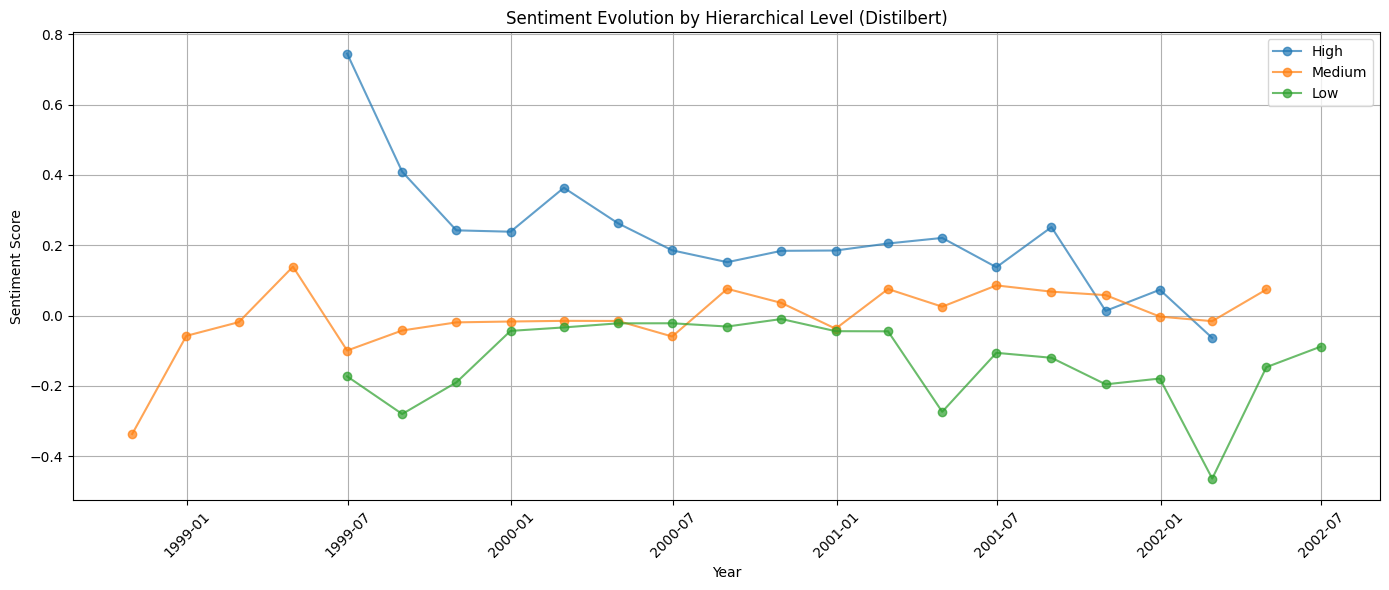

In [ ]:
min_count = 5

agg = (
    df.groupby([pd.Grouper(key='year_month', freq='2M'), 'Level'])
    .agg(Sentiment=('Sentiment_distilbert', 'mean'), Count=('Sentiment_distilbert', 'count'))
    .reset_index()
)

agg = agg[agg['Count'] >= min_count]

pivot = agg.pivot(index='year_month', columns='Level', values='Sentiment').sort_index()

pivot = pivot.reindex(columns=[lvl for lvl in order if lvl in pivot.columns])

plt.figure(figsize=(14, 6))
for lvl in pivot.columns:
    plt.plot(pivot.index, pivot[lvl], marker='o', linestyle='-', alpha=0.7, label=f"{lvl}",color=color_map.get(lvl, 'gray'))

plt.title("Sentiment Evolution by Hierarchical Level (Distilbert)")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Average Sentiment

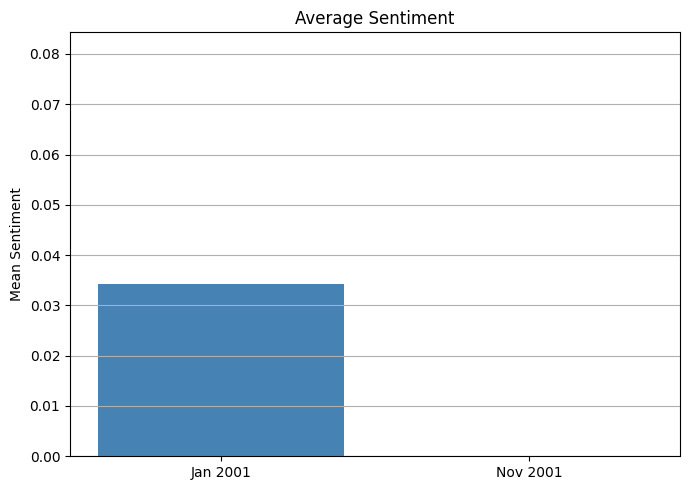

In [ ]:
# Threshold
threshold = 0.1
df['year_month'] = pd.to_datetime(df['year_month'])

# month filter
a_2001 = df[df['year_month'] == '2001-01']
b_2001 = df[df['year_month'] == '2001-11']

mean_a = a_2001['Sentiment_distilbert'].mean()
mean_b = b_2001['Sentiment_distilbert'].mean()

# Barplot
plt.figure(figsize=(7, 5))
means = [mean_a, mean_b]
labels = ['Jan 2001', 'Nov 2001']

plt.bar(labels, means, color='steelblue')
plt.title("Average Sentiment")
plt.ylabel("Mean Sentiment")
plt.ylim(0, max(means) + 0.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()